### Pipeline Multi-Classification

L'objectif de ce notebook est d'expérimenter avec divers modèles pour résoudre une tâche de classification multiclasse. 
Plus précisément, nous cherchons à prédire à partir des données lors d'un demarragge d'un job, quel type de criticité est susceptible de survenenir à savoir; 
- Info
- Warning
- Error
- Aucun

Ce model sera le premier d'une paire de model ayant comme objectif de predire un type d'erreur précis. 
Si ce model predit une erreur, le deuxième model predira le type d'erreur que nous allons rencontré.

In [69]:
import pandas as pd
import numpy as np
import os

from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV,learning_curve

from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, recall_score, roc_curve, auc , roc_auc_score


from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import mlflow
import mlflow.sklearn
from joblib import dump, load
import json




In [70]:
# nom de fichier et chemin relatif
filename = 'dataset_for_training_criticality_balanced_08.1.csv'
path = '../../../data/'
# création d'un dataframe à partir du csv de données
df = pd.read_csv(path+filename, index_col=0)
df.head(2)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events
0,171.889,700,520,740,2,False,1,1,0.059481,10,...,0,45,100,0,1500,1500,1500,16,16,INFO
1,152.296,700,520,740,2,False,1,1,0.060070,10,...,0,45,100,0,1817,1817,1817,19,20,NO_EVENT


In [71]:
df.shape

(18020, 26)

In [72]:
df.columns

Index(['duration', 'speed', 'paperHeight_job', 'paperWidth_job',
       'total_copies_requested', 'ifoil', 'scanner_mode', 'bars_job',
       'varnishConsumptionVarnish_3d_job', 'LED', 'drops', 'speed_ifoil',
       'optifoil_ifoil', 'heater1Enabled_ifoil', 'heater1Temperature_ifoil',
       'x_imageLayout', 'y_imageLayout', 'power_irDryers', 'power_uvDryers',
       'leftMargin_remoteScannerRegistration',
       'redScore_gridMode_remoteScannerRegistration',
       'redScore_cropmarksMode_remoteScannerRegistration',
       'redScore_fullScannerMode_remoteScannerRegistration',
       'blueScore_fullScannerMode_remoteScannerRegistration',
       'greenScore_fullScannerMode_remoteScannerRegistration',
       'criticality_events'],
      dtype='object')

In [73]:
df['criticality_events'].unique()

array(['INFO', 'NO_EVENT', 'WARNING', 'ERROR'], dtype=object)

In [74]:
df['criticality_events'].nunique()

4

In [75]:
df['criticality_events'].value_counts() 

INFO        4505
NO_EVENT    4505
WARNING     4505
ERROR       4505
Name: criticality_events, dtype: int64

In [76]:
# Créer une nouvelle colonne 'binary_class' avec des valeurs booléennes
df['error'] = df['criticality_events'].apply(lambda x: True if x == 'ERROR' else False)

# Séparez les données en deux DataFrames, un pour chaque classe
df_error = df[df['error'] == True]
df_non_error = df[df['error'] == False]

In [77]:
df.head(5)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,criticality_events,error
0,171.889,700,520,740,2,False,1,1,0.059481,10,...,45,100,0,1500,1500,1500,16,16,INFO,False
1,152.296,700,520,740,2,False,1,1,0.060070,10,...,45,100,0,1817,1817,1817,19,20,NO_EVENT,False
2,44.259,700,520,740,2,False,1,1,0.251176,10,...,45,100,0,2484,2484,2484,24,27,INFO,False
3,44.259,700,520,740,2,False,1,1,0.251176,10,...,45,100,0,2484,2484,2484,24,27,NO_EVENT,False
4,68.216,359,520,740,2,False,1,1,0.251337,10,...,45,100,0,2484,2484,2484,24,27,INFO,False


In [78]:
df['error'].value_counts() 

False    13515
True      4505
Name: error, dtype: int64

In [79]:
# Pour équilibrer les classes, divisez la classe 'NON_ERROR' en trois et prenez une partie
# La méthode sample de pandas est utilisée pour générer un échantillon aléatoire d'éléments à partir de notre ensemble de données. 
df_non_error = df_non_error.sample(len(df_non_error)//3, random_state=42)

In [80]:
# Recombinez les deux DataFrames
df_balanced = pd.concat([df_error, df_non_error], axis=0)

# Mélangez les données
df = df_balanced.sample(frac=1, random_state=42)

In [81]:
df['error'].value_counts() 

False    4505
True     4505
Name: error, dtype: int64

In [82]:
df.drop(columns='criticality_events', inplace=True)

In [83]:
df.head(2)

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
8014,81.908,700,520,740,2,False,1,1,0.088040,10,...,0,45,100,0,2348,2348,2348,14,16,False
13783,1076.612,313,740,520,100,True,1,2,46.895164,30,...,0,45,80,0,3135,3135,3135,10,10,False


In [84]:
df.dtypes

duration                                                float64
speed                                                     int64
paperHeight_job                                           int64
paperWidth_job                                            int64
total_copies_requested                                    int64
ifoil                                                      bool
scanner_mode                                              int64
bars_job                                                  int64
varnishConsumptionVarnish_3d_job                        float64
LED                                                       int64
drops                                                     int64
speed_ifoil                                             float64
optifoil_ifoil                                             bool
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                  int64
x_imageLayout                           

In [85]:
df.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
8014,81.908,700,520,740,2,False,1,1,0.088040,10,...,0,45,100,0,2348,2348,2348,14,16,False
13783,1076.612,313,740,520,100,True,1,2,46.895164,30,...,0,45,80,0,3135,3135,3135,10,10,False
952,71.851,313,520,740,34,False,1,2,20.959302,30,...,0,45,100,0,2200,2200,2200,21,22,False
11774,109.919,313,450,320,140,True,1,2,0.941745,30,...,0,45,80,0,3135,3135,3135,11,11,True
3534,2352.338,309,520,740,300,False,1,2,228.897472,10,...,0,45,100,0,3135,3135,3135,33,32,True


In [86]:
# # Encodage de la colonne 'y' avec LabelEncoder
# encoder = LabelEncoder()
# df['criticality_events'] = encoder.fit_transform(df['criticality_events'])

In [87]:
# Séparation des données avec train_test_split
X = df.drop('error', axis=1)
y = df['error']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)



In [88]:
# # True pour utiliser StandardScaler, False pour utiliser MinMaxScaler
# use_standard_scaler = True

# if use_standard_scaler:
#     scaler = StandardScaler()
# else:
#     scaler = MinMaxScaler()

# # Sélectionnez uniquement les colonnes de type float64 pour la normalisation
# float_columns = [col for col, col_type in df.dtypes.items() if col_type in ['float64','int64']]

# df[float_columns] = scaler.fit_transform(df[float_columns])

In [89]:
# fusionn des test set pour l'input json
example_input = pd.concat([X_test, y_test], axis=1)

# 1. Sélectionnez les dernières lignes de `example_input` pour un exemple d'entrée MLFLOW
last_rows_example = example_input.iloc[-5:]

# 2. Créez un objet JSON en utilisant les lignes et noms de colonnes originaux
example_input_json = last_rows_example.to_dict('records')

# Enregistrez l'objet JSON dans un fichier
with open("./mflow_object/input_exemple.json", "w") as f:
    json.dump(example_input_json, f)

In [90]:
example_input.head()

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration,error
13505,3.580,313,450,320,3,True,3,2,0.000000,30,...,0,45,80,0,3135,3135,3135,11,10,True
12760,501.638,700,520,740,1000,False,1,1,155.126849,10,...,0,45,100,0,2285,2285,2285,21,23,False
17338,302.018,313,740,520,30,True,1,2,33.227969,30,...,0,45,80,0,3135,3135,3135,11,11,False
17320,192.873,313,520,740,35,False,1,2,24.048151,30,...,0,45,100,0,3135,3135,3135,11,11,True
14042,1145.889,437,520,740,500,False,1,2,10.019581,10,...,0,45,100,0,3135,3135,3135,11,11,True


In [91]:
# True pour utiliser StandardScaler, False pour utiliser MinMaxScaler
use_standard_scaler = True

if use_standard_scaler:
    scaler = StandardScaler()
else:
    scaler = MinMaxScaler()

# Sélectionnez uniquement les colonnes de type float64 pour la normalisation
num_columns = [col for col, col_type in X_train.dtypes.items() if col_type in ['float64','int64']]

# Ajustez le scaler sur X_train et transformez X_train
X_train[num_columns] = scaler.fit_transform(X_train[num_columns])

# Utilisez le scaler ajusté pour transformer X_test
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [92]:
# Sauvegarde de l'encoder et du scaler
dump(scaler, './mflow_object/scaler.joblib') 
# dump(encoder, './mflow_object/encoder.joblib')

['./mflow_object/scaler.joblib']

In [93]:
y_train.value_counts()

False    3836
True     3822
Name: error, dtype: int64

### Data augmentation

Le code suivant est destiné à faire de la data augmentation sur un jeu de données en utilisant la méthode SMOTE (Synthetic Minority Over-sampling Technique).

Ce code commence par définir l'objet smote qui appliquera la méthode SMOTE à vos données. Il définit ensuite une variable **do_data_augmentation** qui, si elle est réglée sur **True**, indiquera au code d'effectuer une augmentation des données.

Si **do_data_augmentation** est **True**, le code fit et applique SMOTE à X_train et y_train, crée un nouvel ensemble de données augmentées et enregistre le schéma de ces nouvelles données dans input_schema et output_schema. Sinon, le schéma original est enregistré.

Le schéma est ensuite converti en un dictionnaire de types de données convertis en chaînes de caractères et est enregistré dans des fichiers *.json* : **input_schema.json** et **output_schema.json**. Ces fichiers sont utiles pour donner un exemple de ce que le modèle prend en entrée et en sortie.

Avantages de la méthode SMOTE :

Elle permet de surmonter le problème de déséquilibre de classe en augmentant artificiellement le nombre d'exemples dans les classes minoritaires.
Contrairement à d'autres techniques de suréchantillonnage (comme le suréchantillonnage aléatoire), SMOTE crée de nouvelles instances synthétiques plutôt que de simplement dupliquer les instances existantes, ce qui peut aider à prévenir le surapprentissage.

Inconvénients de la méthode SMOTE :

Elle peut générer des instances synthétiques qui sont bruyantes ou qui sont proches de la frontière de décision, ce qui peut rendre le modèle plus complexe et augmenter le risque de surapprentissage.
Elle ne fonctionne pas bien lorsque les classes minoritaires sont fortement déséquilibrées ou lorsque les classes minoritaires sont dispersées, car les instances synthétiques peuvent être créées à des endroits qui ne reflètent pas fidèlement la distribution sous-jacente des données.
Elle ne peut pas créer de nouvelles instances pour les classes qui n'ont qu'une seule instance, car il n'y a pas de voisins à partir desquels apprendre.

In [94]:
# Création d'une instance de l'objet SMOTE.
# SMOTE est une technique de suréchantillonnage qui fonctionne en créant des instances synthétiques des classes minoritaires.
# Ces instances sont créées en sélectionnant un nombre k (par défaut k=5) de voisins les plus proches dans l'espace des caractéristiques pour une instance donnée,
# et en créant une nouvelle instance qui se situe le long des lignes reliant cette instance à ses voisins.
# L'utilisation d'un random_state spécifique garantit que le suréchantillonnage sera toujours le même si vous exécutez à nouveau ce code.
smote = SMOTE(k_neighbors=1,random_state=42)

# Vérifier si vous voulez faire une augmentation des données si sur False les model s'entraineront sur les données initiales
do_data_augmentation = False


if do_data_augmentation:
    # Application de la méthode SMOTE à nos données.
    # Cela crée de nouvelles instances synthétiques des classes minoritaires, ce qui devrait aider à équilibrer les classes.
    # Le résultat est un nouvel ensemble de données X et un nouvel ensemble de labels y  qui contiennent les instances originales 
    # plus les nouvelles instances synthétiques.
    X_train, y_train = smote.fit_resample(X_train, y_train)

    # Sauvegarder le schéma d'entrée et de sortie pour le modèle
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = True
    print(y_train.value_counts())
else:
    input_schema = str(X_train.dtypes)
    output_schema = str(y_train.dtypes)
    data_augmentation_done = False
    print(y_train.value_counts())


# Convertir le schéma d'entrée et de sortie en JSON pour MLflow et les sauvegarder en artefact , 
# le schéma d'entré est trop long pour être sauvegardé avec le format initial 
# (500 caractère max mais plus de 900 dans notre cas) : # mlflow.log_param("input_schema", input_schema)
input_schema = X_train.dtypes.astype(str).to_dict()
output_schema = {"output": str(y_train.dtype)}

y_value_count = y_train.value_counts()

with open("./mflow_object/input_schema.json", "w") as f:
    json.dump(input_schema, f)

# Convertir le schéma de sortie en JSON
with open("./mflow_object/output_schema.json", "w") as f:
    json.dump(output_schema, f)
input_schema

False    3836
True     3822
Name: error, dtype: int64


{'duration': 'float64',
 'speed': 'float64',
 'paperHeight_job': 'float64',
 'paperWidth_job': 'float64',
 'total_copies_requested': 'float64',
 'ifoil': 'bool',
 'scanner_mode': 'float64',
 'bars_job': 'float64',
 'varnishConsumptionVarnish_3d_job': 'float64',
 'LED': 'float64',
 'drops': 'float64',
 'speed_ifoil': 'float64',
 'optifoil_ifoil': 'bool',
 'heater1Enabled_ifoil': 'bool',
 'heater1Temperature_ifoil': 'float64',
 'x_imageLayout': 'float64',
 'y_imageLayout': 'float64',
 'power_irDryers': 'float64',
 'power_uvDryers': 'float64',
 'leftMargin_remoteScannerRegistration': 'float64',
 'redScore_gridMode_remoteScannerRegistration': 'float64',
 'redScore_cropmarksMode_remoteScannerRegistration': 'float64',
 'redScore_fullScannerMode_remoteScannerRegistration': 'float64',
 'blueScore_fullScannerMode_remoteScannerRegistration': 'float64',
 'greenScore_fullScannerMode_remoteScannerRegistration': 'float64'}

In [95]:
X

,duration,speed,paperHeight_job,paperWidth_job,total_copies_requested,ifoil,scanner_mode,bars_job,varnishConsumptionVarnish_3d_job,LED,...,x_imageLayout,y_imageLayout,power_irDryers,power_uvDryers,leftMargin_remoteScannerRegistration,redScore_gridMode_remoteScannerRegistration,redScore_cropmarksMode_remoteScannerRegistration,redScore_fullScannerMode_remoteScannerRegistration,blueScore_fullScannerMode_remoteScannerRegistration,greenScore_fullScannerMode_remoteScannerRegistration
8014,81.908,700,520,740,2,False,1,1,0.088040,10,...,70,0,45,100,0,2348,2348,2348,14,16
13783,1076.612,313,740,520,100,True,1,2,46.895164,30,...,1629,0,45,80,0,3135,3135,3135,10,10
952,71.851,313,520,740,34,False,1,2,20.959302,30,...,70,0,45,100,0,2200,2200,2200,21,22
11774,109.919,313,450,320,140,True,1,2,0.941745,30,...,3047,0,45,80,0,3135,3135,3135,11,11
3534,2352.338,309,520,740,300,False,1,2,228.897472,10,...,70,0,45,100,0,3135,3135,3135,33,32
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2478,3647.615,313,920,650,1000,True,1,2,6.544133,30,...,708,0,45,80,0,1500,1500,1500,16,16
10795,255.713,313,520,740,30,False,1,2,44.415003,30,...,70,0,45,100,0,3135,3135,3135,11,15
13946,187.644,313,450,320,50,True,1,2,3.315875,30,...,3047,0,45,80,0,3135,3135,3135,11,11
3343,20.807,313,450,320,3,False,1,2,0.000000,30,...,3047,-14,45,100,-71,2000,2000,2000,16,16


In [96]:
X_train.dtypes

duration                                                float64
speed                                                   float64
paperHeight_job                                         float64
paperWidth_job                                          float64
total_copies_requested                                  float64
ifoil                                                      bool
scanner_mode                                            float64
bars_job                                                float64
varnishConsumptionVarnish_3d_job                        float64
LED                                                     float64
drops                                                   float64
speed_ifoil                                             float64
optifoil_ifoil                                             bool
heater1Enabled_ifoil                                       bool
heater1Temperature_ifoil                                float64
x_imageLayout                           

### Pipeline
Ce code est divisé en trois cellules

In [97]:
models = {
    "lr": {
        "model": LogisticRegression(solver='lbfgs'),
        "params": {"model__C": [0.1, 1.0, 10.0]}
    },
    "rf": {
        "model": RandomForestClassifier(),
        "params": {
            "model__n_estimators": [25, 50, 100],
            "model__max_depth": [None, 10, 20],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "svc": {
        "model": SVC(probability=True),
        "params": {"model__C": [0.1, 1.0, 10.0], "model__gamma": [0.1, 1.0, 10.0]}
    },
    "xgb": {
        "model": XGBClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "lgbm": {
        "model": LGBMClassifier(),
        "params": {"model__n_estimators": [100, 200, 300], "model__learning_rate": [0.01, 0.1, 0.2]}
    },
    "dt": {
        "model": DecisionTreeClassifier(),
        "params": {
            "model__criterion": ["gini", "entropy"],
            "model__max_depth": [None, 2, 4, 6, 8, 10],
            "model__min_samples_split": [2, 5, 10],
            "model__min_samples_leaf": [1, 2, 4]
        }
    },
    "gbc": {
        "model": GradientBoostingClassifier(),
        "params": {
            "model__n_estimators": [100, 200, 300],
            "model__learning_rate": [0.01, 0.1, 0.2],
            "model__max_depth": [1, 3, 5]
        }
    }
}

# Liste des modèles à inclure
include_models = ["lr", "rf", "svc", "xgb", "lgbm",'dt','gbc']


pipelines = {key: Pipeline([("scaler", scaler), ("model", models[key]["model"])]) for key in include_models}
param_grids = {key: models[key]["params"] for key in include_models}

In [98]:
# Dictionnaire pour renommer les abréviations de modèles par leurs noms complets pour mlflow
model_names = {
    "lr": "Logistic Regression",
    "rf": "Random Forest Classifier",
    "svc": "Support Vector Classifier",
    "xgb" : "XGB Classifier",
    "lgbm" : "LGBM Classifier",
    "dt" : "Decision Tree",
    "gbc" :  "Gradient Boosting Classifier"
}

# Création d'un dictionnaire pour chaque modèle indiquant les hyperparamètres utilisés et leurs valeurs
model_hyperparams_values = {model_names[key]: param_grids[key] for key in include_models}

# Affichage des hyperparamètres de chaque modèle et leurs valeurs
print(model_hyperparams_values)

# Enregistrement des hyperparamètres de chaque modèle et leurs valeurs au format JSON
with open("./mflow_object/model_hyperparams_values.json", "w") as f:
    json.dump(model_hyperparams_values, f)


{'Logistic Regression': {'model__C': [0.1, 1.0, 10.0]}, 'Random Forest Classifier': {'model__n_estimators': [25, 50, 100], 'model__max_depth': [None, 10, 20], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}, 'Support Vector Classifier': {'model__C': [0.1, 1.0, 10.0], 'model__gamma': [0.1, 1.0, 10.0]}, 'XGB Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2]}, 'LGBM Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2]}, 'Decision Tree': {'model__criterion': ['gini', 'entropy'], 'model__max_depth': [None, 2, 4, 6, 8, 10], 'model__min_samples_split': [2, 5, 10], 'model__min_samples_leaf': [1, 2, 4]}, 'Gradient Boosting Classifier': {'model__n_estimators': [100, 200, 300], 'model__learning_rate': [0.01, 0.1, 0.2], 'model__max_depth': [1, 3, 5]}}


In [99]:
# Initialisation de la liste pour stocker les résultats
results = []

# Initialisation du meilleur modèle et du meilleur score
best_model = None
best_score = 0

Voici une description détaillée de chaque partie du code :

**Démarrer une expérience MLflow** : La ligne mlflow.start_run() démarre une nouvelle expérience MLflow, ce qui permet de tracker les différentes métriques, paramètres et artefacts pour chaque modèle.

**Boucle de modélisation et de recherche en grille** : Cette boucle itère sur chaque modèle défini précédemment dans le pipeline. Pour chaque modèle, une recherche en grille (Grid Search) est effectuée sur l'ensemble des paramètres définis pour ce modèle, en utilisant une validation croisée stratifiée de 5-fold (cv=5).

**Entraînement et prédiction** : Le modèle est entraîné sur l'ensemble d'entraînement (X_train et y_train) et ensuite utilisé pour prédire les labels de l'ensemble de test (X_test).

**Évaluation du modèle** : Le modèle est évalué en calculant l'accuracy et le recall sur l'ensemble de test.

**Sélection du meilleur modèle** : Si l'accuracy du modèle actuel est supérieure à celle du meilleur modèle précédemment trouvé, le modèle actuel devient le nouveau meilleur modèle.

**Stockage des résultats** : Les résultats de chaque modèle sont stockés dans une liste sous forme de dictionnaires.

**Courbe d'apprentissage** : Les courbes d'apprentissage sont générées pour chaque modèle en utilisant la fonction learning_curve. Cette fonction génère un graphique montrant l'évolution de l'accuracy en fonction de la taille de l'échantillon d'entraînement. Elle est utilisée pour vérifier si le modèle souffre de sous-apprentissage ou de sur-apprentissage.

**Enregistrement des modèles et des artefacts avec MLflow** : Les informations sur les modèles, comme l'accuracy, le recall, les courbes d'apprentissage, les schémas d'entrée et de sortie, les hyperparamètres utilisés, etc., sont enregistrées avec MLflow pour un suivi facile.

**Sauvegarde du meilleur modèle** : Le meilleur modèle (avec la meilleure accuracy) est enregistré pour une utilisation future.

**Conversion des résultats en DataFrame** : Les résultats sont convertis en un DataFrame pour faciliter la visualisation et l'analyse.

In [100]:
mlflow.start_run(run_name='Criticality classification Binary-classification')

# Boucle sur les pipelines et effectue une recherche sur grille pour chaque modèle
for model_name, pipeline in pipelines.items():
    # Création d'une instance de GridSearchCV avec le pipeline et les paramètres correspondants
    model = GridSearchCV(pipeline, param_grids[model_name], cv=5, verbose=2, n_jobs=-1, scoring='accuracy')
    # Entraînement du modèle GridSearchCV sur l'ensemble d'entraînement
    model.fit(X_train, y_train)
        
    # Prédiction sur l'ensemble de test
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]  # Predict probabilities for the positive class

        
    # Calcul de l'accuracy et du recall sur l'ensemble de test
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred, average='macro') # "macro" pour le recall non pondéré
    roc_auc = roc_auc_score(y_test, y_pred_proba)  # Calculate AUC-ROC

 
    # Calcul du score moyen
    average_score = (accuracy + recall + roc_auc) / 3

    # Pour donner plus d'importance à une metric 
    # average_score = (2 * accuracy + recall + roc_auc) / 4


    # Mise à jour du meilleur modèle si le score moyen de l'actuel est meilleur
    if average_score > best_score:
        best_model = model
        best_score = average_score
        best_model_name = model_name

    # Stockage des résultats dans une liste
    results.append({"model": model_name, "accuracy": accuracy, "recall": recall, "roc_auc" : roc_auc})
        
    # Enregistrement de l'accuracy et du recall avec mlflow
    mlflow.log_metric(f"{model_name}_accuracy", accuracy)
    mlflow.log_metric(f"{model_name}_recall", recall)
    mlflow.log_metric(f"{model_name}_roc_auc", roc_auc)


    # Génération de la courbe d'apprentissage
    train_sizes, train_scores, test_scores = learning_curve(
        model.best_estimator_, X_train, y_train, cv=5, scoring='accuracy', 
        train_sizes=np.linspace(.1, 1.0, 5))
    plt.figure()
    plt.plot(train_sizes, np.mean(train_scores, axis=1), 'o-', label="Training score")
    plt.plot(train_sizes, np.mean(test_scores, axis=1), 'o-', label="Cross-validation score")
    plt.title(f"{model_name} Learning Curve")
    plt.xlabel("Training examples")
    plt.ylabel("Score")
    plt.legend(loc="best")
    plt.grid()

    # Sauvegarde de la figure de la courbe d'apprentissage
    plt.savefig(f"./mflow_object/{model_name}_learning_curve.png")
    
    # Enregistrement de la figure de la courbe d'apprentissage avec mlflow
    mlflow.log_artifact(f"./mflow_object/{model_name}_learning_curve.png")
    
    # Génération de la courbe ROC
    plt.figure()
    fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'{model_name} ROC Curve')
    plt.legend(loc="lower right")

    # Sauvegarde de la figure de la courbe ROC
    plt.savefig(f"./mflow_object/{model_name}_roc_curve.png")
    
    # Enregistrement de la figure de la courbe ROC avec mlflow
    mlflow.log_artifact(f"./mflow_object/{model_name}_roc_curve.png")

        

# Sauvegarde du meilleur modèle
mlflow.sklearn.log_model(best_model.best_estimator_, f"best_model_{best_model_name}")

# Enregistrer les schémas comme artefacts MLflow
mlflow.log_artifact("./mflow_object/input_schema.json")
mlflow.log_artifact("./mflow_object/output_schema.json")

# Enregistrement d'un exemple pour l'API 
mlflow.log_artifact("./mflow_object/input_exemple.json")

# Enregistrement des modèles avec leurs hyperparamètres qui ont été utilisés dans le pipeline
# mlflow.log_param("model_hyperparams", model_hyperparams_values)
mlflow.log_artifact("./mflow_object/model_hyperparams_values.json")


   
# Sauvegarder si une augmentation de données a été attribuée
mlflow.log_param("data_augmentation", data_augmentation_done)

# Sauvegarde des encoder et scaler pour le run
mlflow.log_artifact('./mflow_object/scaler.joblib')
mlflow.log_artifact('./mflow_object/encoder.joblib')

# Conversion des résultats en DataFrame pour faciliter le traçage
results_df = pd.DataFrame(results)

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Fitting 5 folds for each of 81 candidates, totalling 405 fits
Fitting 5 folds for each of 9 candidates, totalling 45 fits


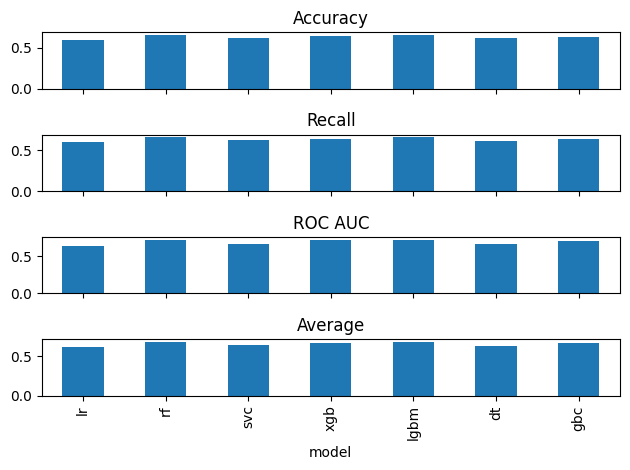

Le meilleur modèle de prediction de criticité du run est Pipeline(steps=[('scaler', StandardScaler()),
                ('model',
                 LGBMClassifier(learning_rate=0.01, n_estimators=300))]) avec une accuracy , un recall moyen et une ROC-AUC de 0.680


In [ ]:
# Calcul de la moyenne des trois métriques pour chaque modèle
results_df['average'] = results_df[['accuracy', 'recall', 'roc_auc']].mean(axis=1)

# Tracé des résultats
fig, ax = plt.subplots(4, 1, sharex=True)
results_df.plot(kind='bar', x='model', y='accuracy', ax=ax[0], legend=False, title='Accuracy')
results_df.plot(kind='bar', x='model', y='recall', ax=ax[1], legend=False, title='Recall')
results_df.plot(kind='bar', x='model', y='roc_auc', ax=ax[2], legend=False, title='ROC AUC')
results_df.plot(kind='bar', x='model', y='average', ax=ax[3], legend=False, title='Average')

plt.tight_layout()

# Enregistrement du plot dans un fichier
plt.savefig("./mflow_object/evaluation_metrics_plot.png")
# Affichage du plot
plt.show()

# Enregistrement du fichier dans MLflow
mlflow.log_artifact("./mflow_object/evaluation_metrics_plot.png")

# Affichage du meilleur modèle
best_model_info = f"Le meilleur modèle de prediction de criticité du run est {best_model.best_estimator_} avec une accuracy , un recall moyen et une ROC-AUC de {best_score:.3f}"
print(best_model_info)


# Enregistrement des hyperparamètres de chaque modèle au format JSON
with open("./mflow_object/best_model_info.json", "w") as f:
    json.dump(best_model_info, f)


# Enregistrement de l'information du meilleur modèle dans MLflow
mlflow.log_artifact("./mflow_object/best_model_info.json")

# Convertion du DataFrame en un dictionnaire
results_dict = results_df.to_dict()

# Restructuration de dictionnaire
restructured_dict = {}
for i in range(len(results_dict['model'])):
    restructured_dict[results_dict['model'][(i)]] = {
        'metrics': {
            'accuracy': results_dict['accuracy'][(i)],
            'recall': results_dict['recall'][(i)],
            'average': results_dict['average'][(i)]
        }
    }


# Ecriture du dictionnaire dans un fichier JSON
with open('./mflow_object/result_test_model.json', 'w') as f:
    json.dump(restructured_dict, f)

# Enregistretement du fichier en tant qu'artefact MLflow
mlflow.log_artifact('./mflow_object/result_test_model.json')

In [ ]:
# Prédiction avec le meilleur modèle sur l'ensemble de test
y_pred_best = best_model.predict(X_test)

# Calcul du recall général pour le meilleur modèle
recall_general_best = recall_score(y_test, y_pred_best, average='macro')

# Génération de la matrice de confusion
cm = confusion_matrix(y_test, best_model.predict(X_test))

# # Décodage des classes
# classes = encoder.inverse_transform([i for i in range(len(cm))])

# Classes are simply True and False or 0 and 1
classes = np.unique(y_test)

# Création du DataFrame
cm_df = pd.DataFrame(cm, index=classes, columns=classes)

# Enregistrement du DataFrame en format CSV
cm_df.to_csv("./mflow_object/confusion_matrix.csv")

# Enregistrement du fichier CSV dans MLflow
mlflow.log_artifact("./mflow_object/confusion_matrix.csv")

# Génération du rapport de classification
report = classification_report(y_test, best_model.predict(X_test), target_names=classes.astype(str))

# Enregistrement du rapport dans un fichier texte
with open("./mflow_object/classification_report.txt", "w") as f:
    f.write(report)

# Enregistrement du fichier texte dans MLflow
mlflow.log_artifact("./mflow_object/classification_report.txt")

print(report)

# End MLflow tracking
mlflow.end_run()

              precision    recall  f1-score   support

       False       0.64      0.70      0.67       669
        True       0.68      0.61      0.64       683

    accuracy                           0.66      1352
   macro avg       0.66      0.66      0.66      1352
weighted avg       0.66      0.66      0.66      1352

